## Capstone Project Battle of the Neighbourhoods - Week4

#### Problem
Description: An International NPO is looking to open a Tradeschool in Cape Town. Once students are trained they will have the skills to start their own business and manufacture their own goods to sell at flea markets. The skills that will be taught is Carpentry, Electrician, Ironworker, Plumber and Welder. The impact the NPO wants to make is aleviate poverty and unemployment in the City.


### Data description
I will be looking at the Cost of living for 3 Cities first, so there can be an idea of how this different the costs are in cities located in devoloped countries vs a city in a developing country, this data I will obtain from from www.expatistan.com and various other sources. I will use the foursquare API to map the locations of Tradeschools, Factories, Home Services and Fleamarkets in Cape Town to see if it will be a viable proposal for to have a tradeschool in the city and see if it is possible to get the data for some settlements such as the Highest education levels and place that on the map as well. The link to the project on github is https://github.com/pieterdt1979/coursera_capstone/tree/master/Capstone-Week4-5

In [67]:
## Importing all the modules that will be needed
# Some data will be scraped from the below site
# http://www.statssa.gov.za/?page_id=1021&id=city-of-cape-town-municipality
# 
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')
from requests import get  # To scrape cost of living as well from:
from bs4 import BeautifulSoup   # https://www.expatistan.com/cost-of-living/toronto?currency=USD
                                # https://www.expatistan.com/cost-of-living/cape-town?currency=USD
                                # https://www.expatistan.com/cost-of-living/new-york
import tradingeconomics as te
import folium
from sklearn.cluster import KMeans
import json
from datetime import datetime
import time
import csv
import sys

In [68]:
# Now we can get the cost of living for each country
tor_col = pd.read_html('https://www.expatistan.com/cost-of-living/toronto?currency=USD')
cpt_col = pd.read_html('https://www.expatistan.com/cost-of-living/cape-town?currency=USD')
ny_col = pd.read_html('https://www.expatistan.com/cost-of-living/new-york-city')

In [69]:
#Fix the data for the ny as we will be adding the columns for the two other cities to it
ny_col[0].drop('Food', axis=1, inplace=True)
ny_col[0].drop('Unnamed: 3', axis=1, inplace=True)
ny_col[0].rename(columns={'Food.1':'Expense Types', '[Edit]':'New York'}, inplace=True)
ny_col[0].drop([13,25,26,31,36,46], inplace=True)
ny_col[0].reset_index(drop=True, inplace=True)
ny_col[0].shape

(52, 2)

In [70]:
tor_col[0].drop([0,14,15,27,28,29,34,35,40,41,51,52], inplace=True)
tor_col[0].reset_index(drop=True, inplace=True)
tor_col[0].shape

(52, 4)

In [71]:
cpt_col[0].drop([0,14,15,27,28,29,34,35,40,41,51,52], inplace=True)
cpt_col[0].reset_index(drop=True, inplace=True)
cpt_col[0].shape

(52, 4)

In [72]:
ny_col[0]['Canada'] = tor_col[0][tor_col[0].columns[3]]

In [73]:
ny_col[0]['Cape Town'] = cpt_col[0][cpt_col[0].columns[3]]

In [74]:
combined = pd.DataFrame(ny_col[0])
print('Data Types: ',combined.dtypes)
combined.head(5)

Data Types:  Expense Types    object
New York         object
Canada           object
Cape Town        object
dtype: object


,Expense Types,New York,Canada,Cape Town
0,Basic lunchtime menu (including a drink) in th...,$17,($13),($8)
1,Combo meal in fast food restaurant (Big Mac Me...,$9,($8),($4.03)
2,500 gr (1 lb.) of boneless chicken breast,$6,($5.74),($3.08)
3,1 liter (1 qt.) of whole fat milk,$1.20,($2.16),($0.85)
4,"12 eggs, large",$4.59,($2.88),($2.18)


In [75]:
# The data needs to be cleaned some moreso that the dollar values for each country is displayed as floats
# df[["bore", "stroke"]] = df[["bore", "stroke"]].astype("float")
combined[['New York', 'Canada', 'Cape Town']]=combined[['New York', 'Canada', 'Cape Town']].replace(to_replace=r'\$',
                                                                                                    value='', regex=True)
combined[['New York', 'Canada', 'Cape Town']]=combined[['New York', 'Canada', 'Cape Town']].replace(to_replace=r'\(',
                                                                                                    value='', regex=True)
combined[['New York', 'Canada', 'Cape Town']]=combined[['New York', 'Canada', 'Cape Town']].replace(to_replace=r'\)',
                                                                                                    value='', regex=True)
combined[['New York', 'Canada', 'Cape Town']]=combined[['New York', 'Canada', 'Cape Town']].replace(to_replace=r'\,',
                                                                                                    value='', regex=True)

In [76]:
combined[['New York', 'Canada', 'Cape Town']] = combined[['New York', 'Canada', 'Cape Town']].astype("float")
print(combined.dtypes) # Peeking the data types again
combined.head(5) # Just checking that nothing was lost in the conversion

Expense Types     object
New York         float64
Canada           float64
Cape Town        float64
dtype: object


,Expense Types,New York,Canada,Cape Town
0,Basic lunchtime menu (including a drink) in th...,17.00,13.00,8.00
1,Combo meal in fast food restaurant (Big Mac Me...,9.00,8.00,4.03
2,500 gr (1 lb.) of boneless chicken breast,6.00,5.74,3.08
3,1 liter (1 qt.) of whole fat milk,1.20,2.16,0.85
4,"12 eggs, large",4.59,2.88,2.18


In [77]:
combined.set_index('Expense Types', inplace=True) # Change the index

In [78]:
combined[32:41]

,New York,Canada,Cape Town
Expense Types,,,
"Cold medicine for 6 days (Tylenol, Frenadol, Coldrex, or equivalent brands)",9.00,9.00,4.35
1 box of antibiotics (12 doses),27.00,21.00,10.00
Short visit to private Doctor (15 minutes),142.00,73.00,29.00
"1 box of 32 tampons (Tampax, OB, ...)",8.00,5.24,2.96
"Deodorant, roll-on (50ml ~ 1.5 oz.)",4.70,3.64,2.05
Hair shampoo 2-in-1 (400 ml ~ 12 oz.),6.00,3.64,3.65
4 rolls of toilet paper,4.12,2.00,1.52
Tube of toothpaste,1.98,1.88,1.36
Standard men's haircut in expat area of the city,28.00,19.00,9.00


In [79]:
# Splitting it for the different categories
food_comp = combined[0:13]
housing_comp = combined[13:24]
clothing_comp = combined[24:28]
transport_comp = combined[28:32]
care_comp = combined[32:41]
entertain_comp = combined[41:]

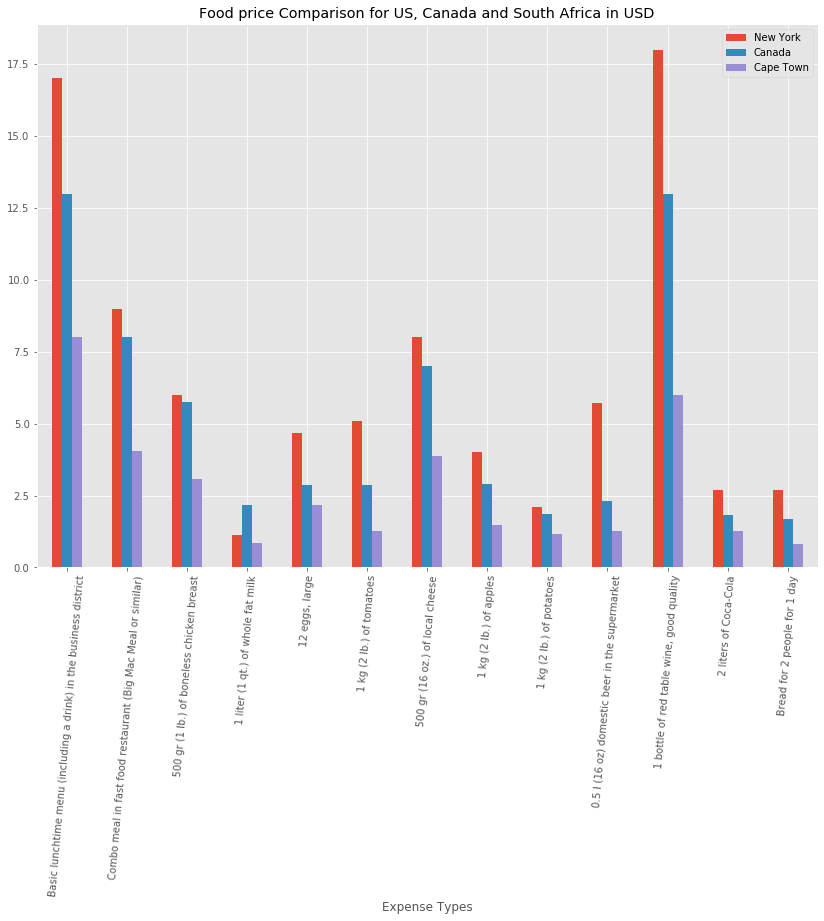

In [17]:
food_comp.plot(kind='bar', figsize=(14,10), rot=85)
plt.title('Food price Comparison for US, Canada and South Africa in USD')
plt.savefig('food_comp.jpg')

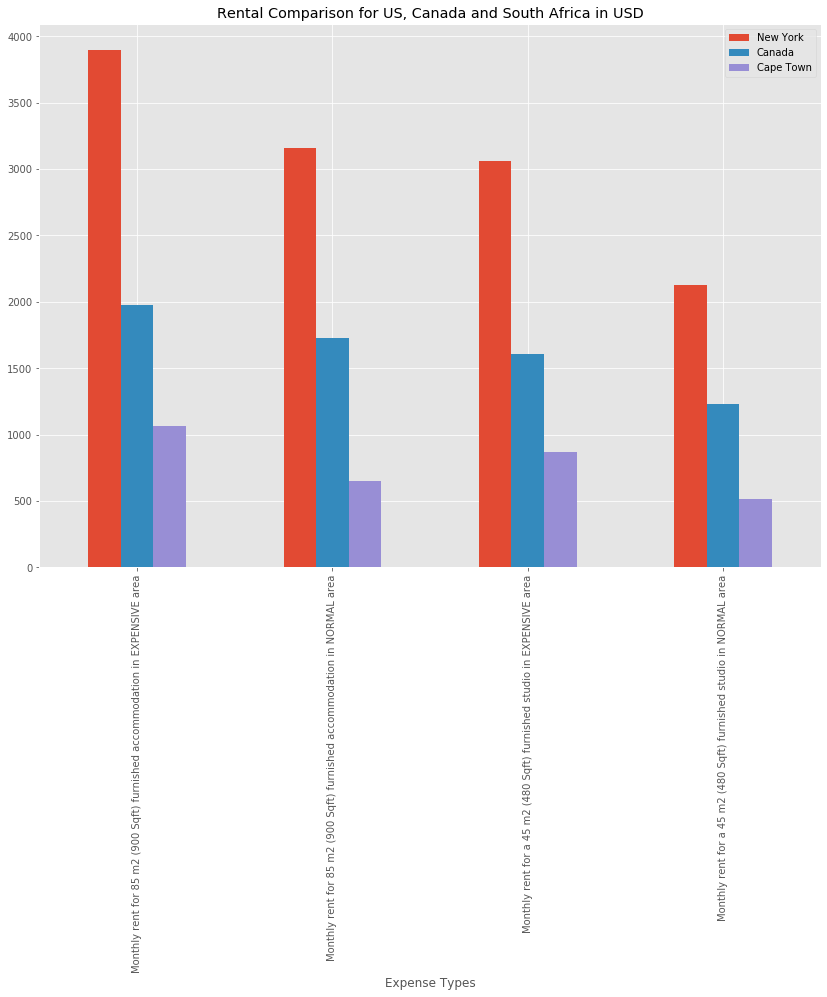

In [80]:
pd.DataFrame(housing_comp[0:2].append(housing_comp[3:5])).plot(kind='bar', figsize=(14,10))
plt.title('Rental Comparison for US, Canada and South Africa in USD')
plt.savefig('rental_comp.jpg')

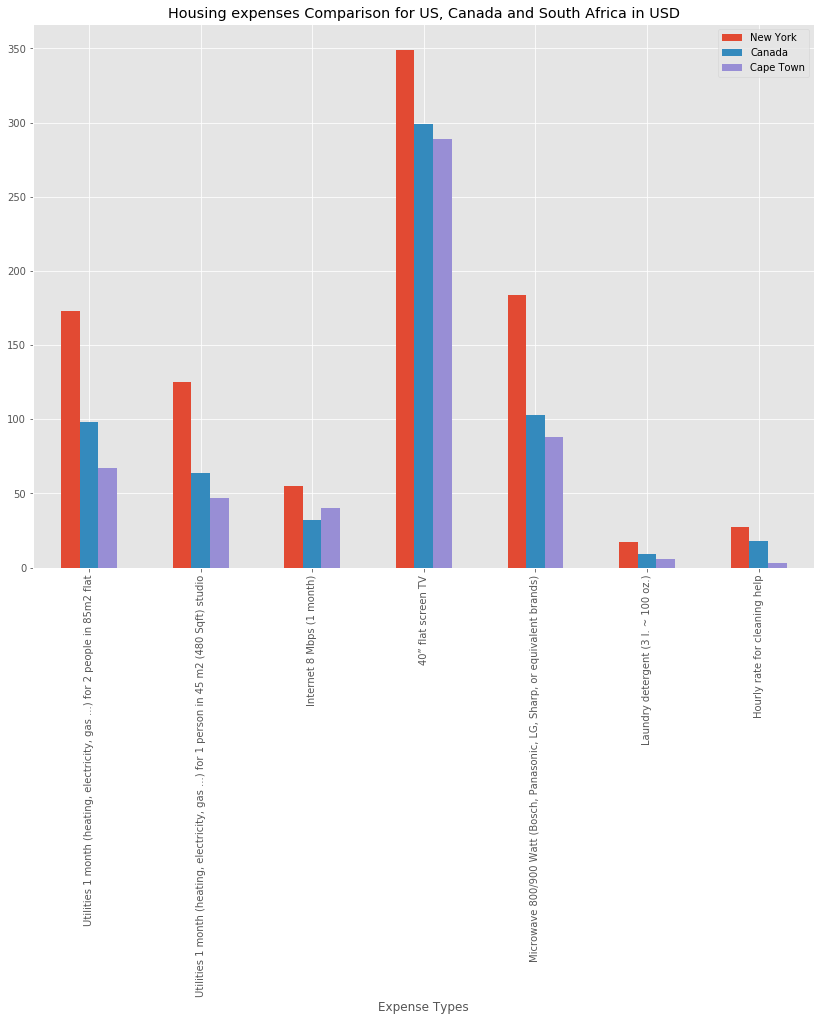

In [81]:
pd.DataFrame(housing_comp[2:3].append(housing_comp[5:])).plot(kind='bar', figsize=(14,10))
plt.title('Housing expenses Comparison for US, Canada and South Africa in USD')
plt.savefig('house_hold.jpg')

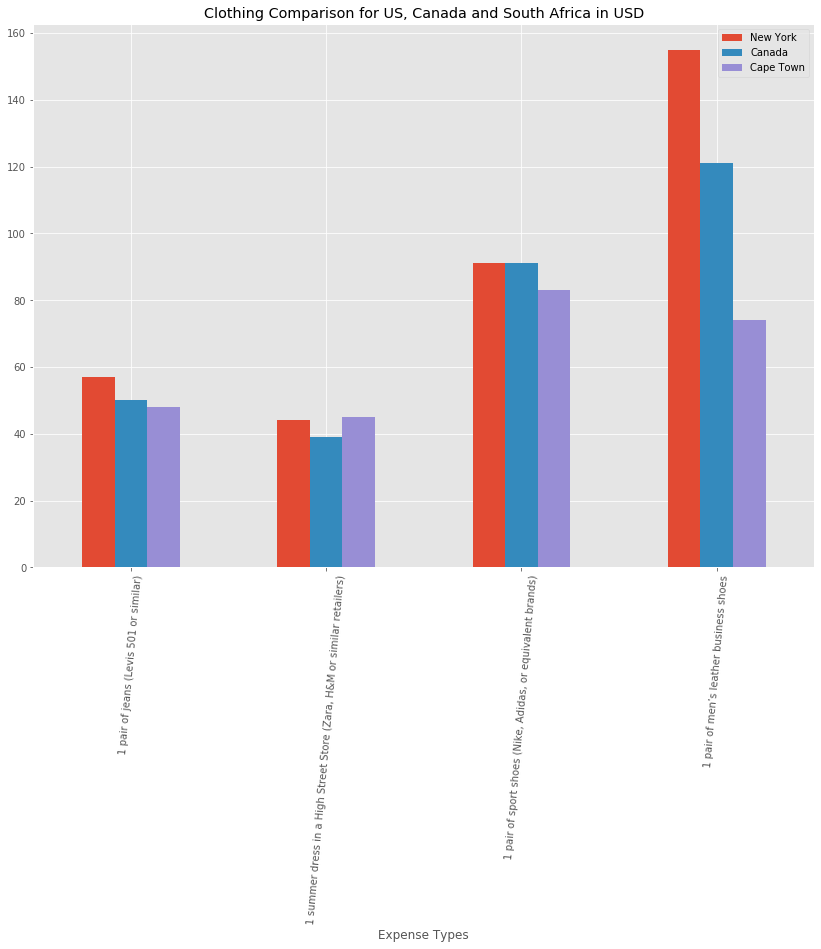

In [20]:
clothing_comp.plot(kind='bar', figsize=(14,10), rot=85)
plt.title('Clothing Comparison for US, Canada and South Africa in USD')
plt.savefig('clothing_comp.jpg')

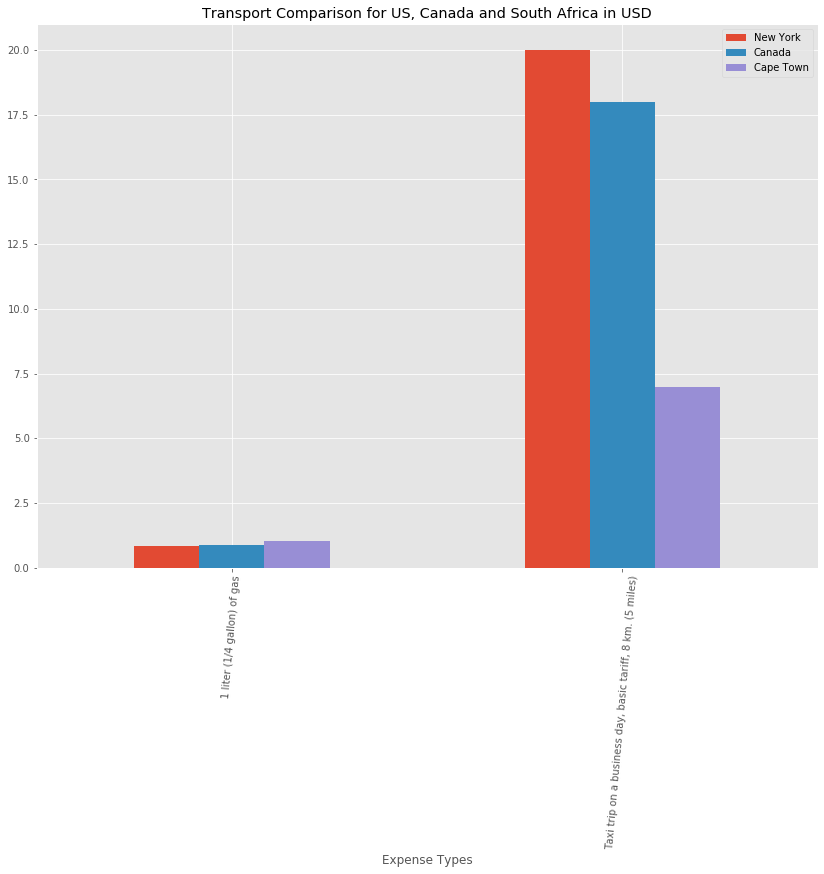

In [82]:
transport_comp[1::2].plot(kind='bar', figsize=(14,10), rot=85)
plt.title('Transport Comparison for US, Canada and South Africa in USD')
plt.savefig('transport_comp_1.jpg') # Interesting Fuel in South-Africa is more expensive, but the taxi trip are cheaper

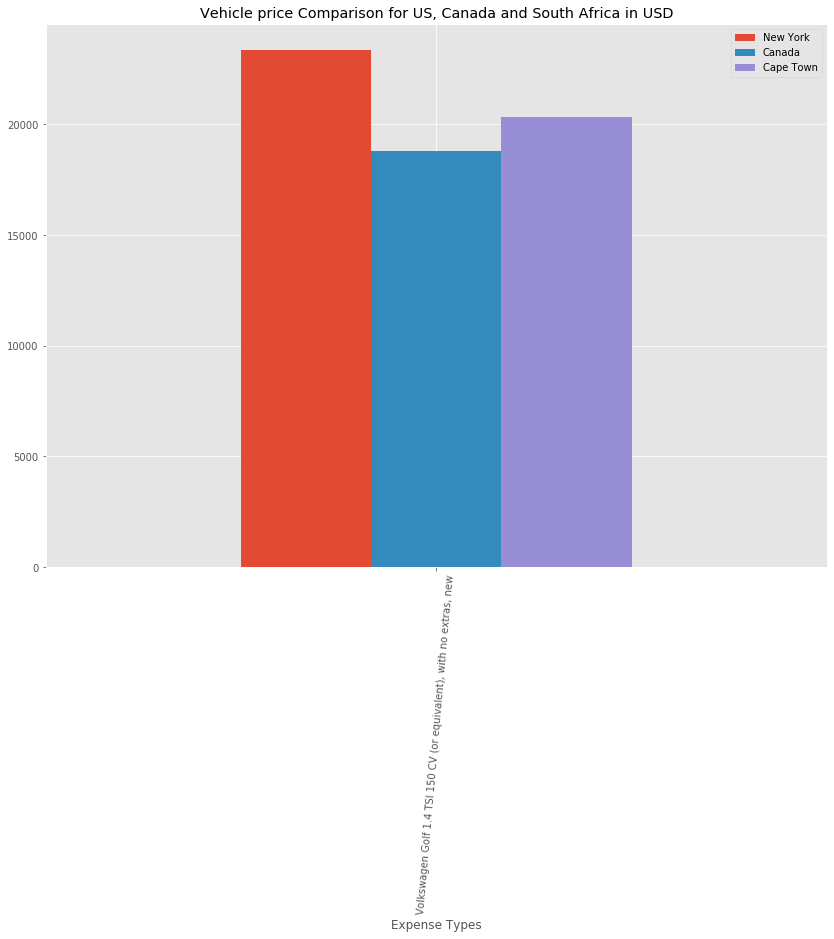

In [22]:
transport_comp[0:1].plot(kind='bar', figsize=(14,10), rot=85)
plt.title('Vehicle price Comparison for US, Canada and South Africa in USD')
plt.savefig('transport_comp_2.jpg') 

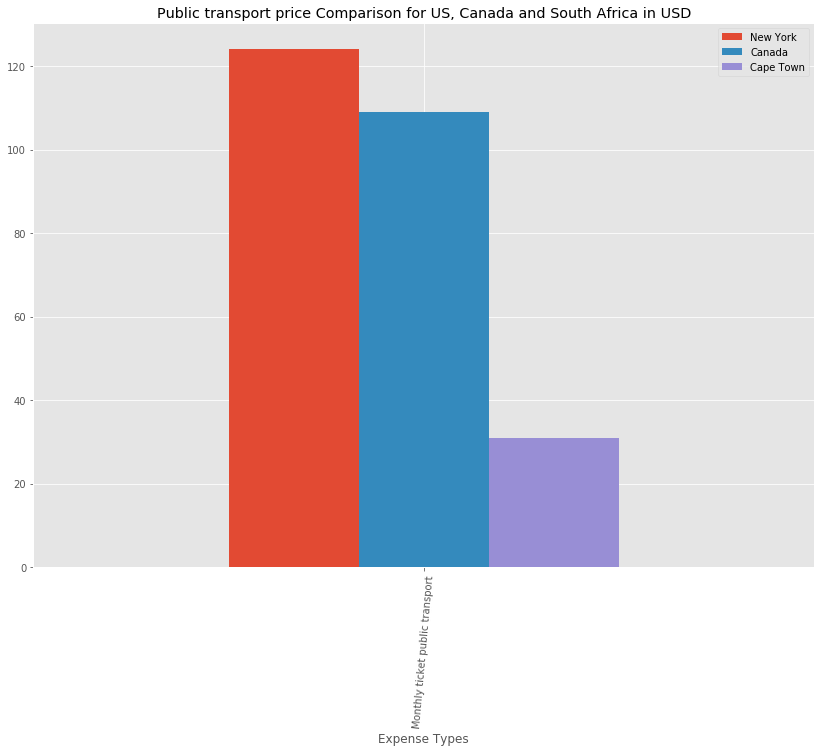

In [83]:
transport_comp[2:3].plot(kind='bar', figsize=(14,10), rot=85)
plt.title('Public transport price Comparison for US, Canada and South Africa in USD')
plt.savefig('transport_comp_3.jpg') # Still wondering about the fuel that is more expensive, yet public transport is also cheaper

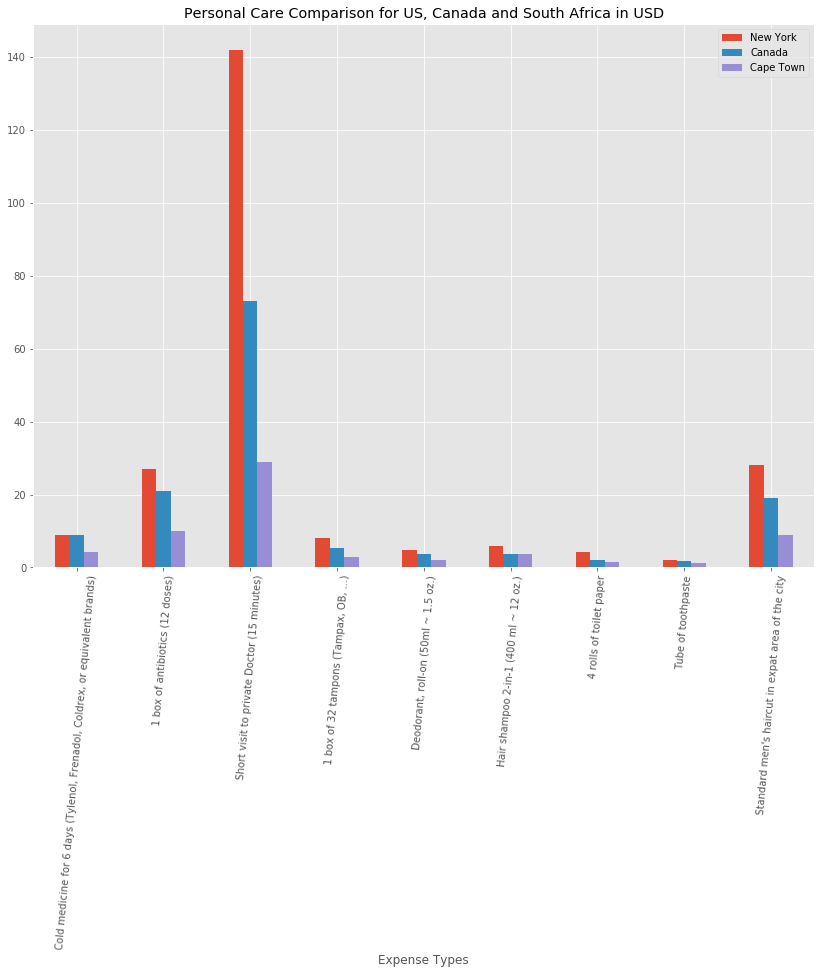

In [84]:
care_comp.plot(kind='bar', figsize=(14,10), rot=85)
plt.title('Personal Care Comparison for US, Canada and South Africa in USD')
plt.savefig('personal_care_comp.jpg') 

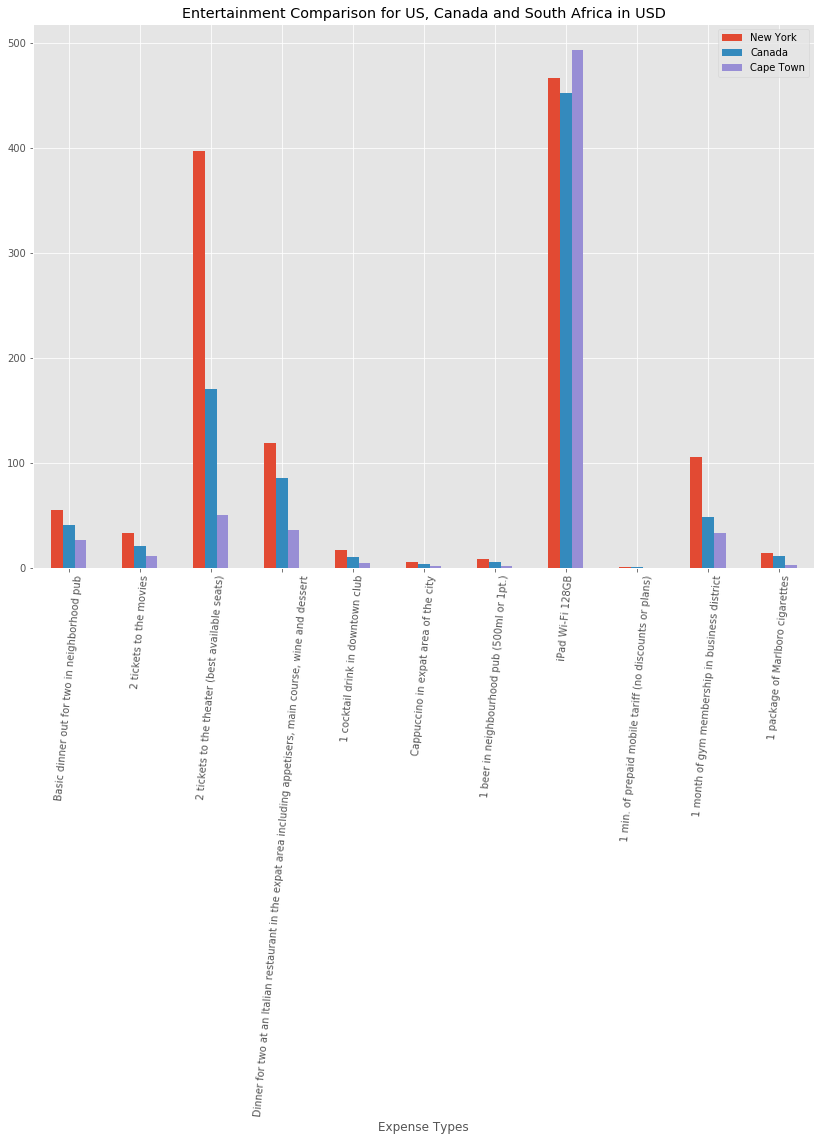

In [25]:
entertain_comp.plot(kind='bar', figsize=(14,10), rot=85)
plt.title('Entertainment Comparison for US, Canada and South Africa in USD')
plt.savefig('entertainment.jpg')

In [85]:
#Function to get the nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius=5000, categoryids=[]):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        if len(categoryids) > 0:
            url = url + '&categoryId={}'.format(','.join(categoryids))
            
        # make the GET request
        results = get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        try:    
            venues_list.append([(
                name.split(',')[0], 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            pass
    try:
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Settlement',  
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category']
    except:
        nearby_venues = pd.DataFrame(columns=['Settlement', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category'])

    
    return(nearby_venues)

In [86]:
CLIENT_ID = 'LH2OJQC5DUE5Y3TQZVD3DXDH2A3ASD5MANEVAKEMGDJN0HWT' # your Foursquare ID
CLIENT_SECRET = 'YRM0HCKVDAG5GJU1JYCKPMUWJD0IZUVF1N0ZY3GRKLC3MXT3' # your Foursquare Secret
VERSION = '20191005' # Foursquare API version
LIMIT = 500

In [28]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values (OpenStreetMaps)

def get_geo(address):
    address = address
    geolocator = Nominatim(user_agent="my-application")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return address, latitude, longitude


In [48]:
#So let us start exploring the different Settlements in Cape Town
cities = ['Athlone, Cape Town, ZA', 'Toronto, CA', 'Cape Town, ZA']
latitudes = []
longitudes = []
for c in cities:
    print(c)
    address, lat, long = get_geo(c)
    latitudes.append(lat)
    longitudes.append(long)
tradeschools = '4bf58dd8d48988d1ad941735' # 4Square tradeschools
factories = '4bf58dd8d48988d1e5931735' # 4Square factories
flea_markets = '4bf58dd8d48988d1f7941735' # 4Square flea markets
nearby_venues = getNearbyVenues(cities, latitudes=latitudes, longitudes=longitudes, 
                                radius=20000, categoryids=[tradeschools, factories, flea_markets])
nearby_venues

New York, NY
Toronto, CA
Cape Town, ZA
New York, NY
Toronto, CA
Cape Town, ZA


,Address,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"New York, NY",40.712728,-74.006015,The Rooftop @ Pier 17,40.705463,-74.001598,Music Venue
1,"New York, NY",40.712728,-74.006015,Lavo,40.762657,-73.971688,Nightclub
2,"New York, NY",40.712728,-74.006015,Le Bain,40.740842,-74.008545,Nightclub
3,"New York, NY",40.712728,-74.006015,Paul's Cocktail Lounge,40.719563,-74.005035,Nightclub
4,"New York, NY",40.712728,-74.006015,Joe's Pub,40.729275,-73.991959,Music Venue
5,"New York, NY",40.712728,-74.006015,Studio 54,40.763944,-73.983980,Theater
6,"New York, NY",40.712728,-74.006015,Electric Room,40.742132,-74.003616,Nightclub
7,"New York, NY",40.712728,-74.006015,SubCulture: Arts Underground,40.725790,-73.994485,Music Venue
8,"New York, NY",40.712728,-74.006015,Yext,40.740663,-73.986246,Tech Startup
9,"New York, NY",40.712728,-74.006015,Spring Studios,40.720915,-74.006207,Event Space


In [49]:
nearby_venues['Venue Category'].value_counts()

Nightclub                84
Music Venue              46
Tech Startup             46
Bar                      17
Rock Club                 6
Lounge                    4
Performing Arts Venue     3
Church                    2
Basketball Stadium        2
Café                      2
Theater                   2
Gay Bar                   2
Hockey Arena              2
Bowling Alley             2
Cocktail Bar              2
Piano Bar                 1
Hotel                     1
Plaza                     1
Event Space               1
Football Stadium          1
American Restaurant       1
Karaoke Bar               1
Wine Bar                  1
Gastropub                 1
General Entertainment     1
Music Store               1
School                    1
Beer Bar                  1
Pub                       1
Roof Deck                 1
Steakhouse                1
Government Building       1
BBQ Joint                 1
Office                    1
Tapas Restaurant          1
Record Shop         

From the above we see that there is overall 120 Nightclubs in the 3 Cities and there is 82 Tech Startups

In [50]:
# Analyzing each city
# one hot encoding
venues_onehot = pd.get_dummies(nearby_venues[['Venue Category']], prefix="", prefix_sep="")
# add Address column back to dataframe
venues_onehot['Address'] = nearby_venues['Address'] 

# move neighborhood column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

venues_onehot.head()


,Address,American Restaurant,BBQ Joint,Bar,Basketball Stadium,Beer Bar,Bowling Alley,Café,Church,Cocktail Bar,...,Record Shop,Rock Club,Roof Deck,School,Steakhouse,Tapas Restaurant,Tech Startup,Theater,Waterfront,Wine Bar
0,"New York, NY",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"New York, NY",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"New York, NY",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"New York, NY",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"New York, NY",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
# Examine the new dataframe
venues_onehot.shape

(245, 39)

In [52]:
#Group the rows by city
cities_grouped = venues_onehot.groupby('Address').mean().reset_index()
cities_grouped

,Address,American Restaurant,BBQ Joint,Bar,Basketball Stadium,Beer Bar,Bowling Alley,Café,Church,Cocktail Bar,...,Record Shop,Rock Club,Roof Deck,School,Steakhouse,Tapas Restaurant,Tech Startup,Theater,Waterfront,Wine Bar
0,"Cape Town, ZA",0.00,0.00,0.00,0.00,0.00,0.00,0.044444,0.00,0.00,...,0.00,0.00,0.00,0.00,0.022222,0.022222,0.311111,0.00,0.00,0.00
1,"New York, NY",0.01,0.01,0.10,0.02,0.00,0.01,0.000000,0.02,0.02,...,0.01,0.02,0.01,0.01,0.000000,0.000000,0.020000,0.02,0.01,0.01
2,"Toronto, CA",0.00,0.00,0.07,0.00,0.01,0.01,0.000000,0.00,0.00,...,0.00,0.04,0.00,0.00,0.000000,0.000000,0.300000,0.00,0.00,0.00


In [53]:
# Check the new size
cities_grouped.shape

(3, 39)

In [56]:
num_top_venues = 5

for city in cities_grouped['Address']:
    print("----"+city+"----")
    temp = cities_grouped[cities_grouped['Address'] == city].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Cape Town, ZA----
              venue  freq
0         Nightclub  0.44
1      Tech Startup  0.31
2       Music Venue  0.11
3              Café  0.04
4  Tapas Restaurant  0.02


----New York, NY----
                   venue  freq
0              Nightclub  0.34
1            Music Venue  0.24
2                    Bar  0.10
3  Performing Arts Venue  0.03
4     Basketball Stadium  0.02


----Toronto, CA----
          venue  freq
0     Nightclub  0.30
1  Tech Startup  0.30
2   Music Venue  0.17
3           Bar  0.07
4     Rock Club  0.04




In [57]:
#Function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [58]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Address']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['Address'] = cities_grouped['Address']

for ind in np.arange(cities_grouped.shape[0]):
    cities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cities_grouped.iloc[ind, :], num_top_venues)

cities_venues_sorted.head()

,Address,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Cape Town, ZA",Nightclub,Tech Startup,Music Venue,Café,Tapas Restaurant,Steakhouse,Music Store,Piano Bar,Wine Bar,Event Space
1,"New York, NY",Nightclub,Music Venue,Bar,Performing Arts Venue,Church,Theater,Tech Startup,Basketball Stadium,Rock Club,Cocktail Bar
2,"Toronto, CA",Nightclub,Tech Startup,Music Venue,Bar,Rock Club,Lounge,Hotel,Beer Bar,Bowling Alley,Gay Bar


In [59]:
# Run k-means to cluster the neighbourhoods into 5 clusters
kclusters = 3

cities_grouped_clustering = cities_grouped.drop('Address', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cities_grouped_clustering)
# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:3]

array([0, 1, 2], dtype=int32)

In [60]:
# add clustering labels
cities_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

venues_merged = nearby_venues
# Merge the data
venues_merged = venues_merged.join(cities_venues_sorted.set_index('Address'), on='Address')

In [61]:
venues_merged.head()

,Address,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"New York, NY",40.712728,-74.006015,The Rooftop @ Pier 17,40.705463,-74.001598,Music Venue,1,Nightclub,Music Venue,Bar,Performing Arts Venue,Church,Theater,Tech Startup,Basketball Stadium,Rock Club,Cocktail Bar
1,"New York, NY",40.712728,-74.006015,Lavo,40.762657,-73.971688,Nightclub,1,Nightclub,Music Venue,Bar,Performing Arts Venue,Church,Theater,Tech Startup,Basketball Stadium,Rock Club,Cocktail Bar
2,"New York, NY",40.712728,-74.006015,Le Bain,40.740842,-74.008545,Nightclub,1,Nightclub,Music Venue,Bar,Performing Arts Venue,Church,Theater,Tech Startup,Basketball Stadium,Rock Club,Cocktail Bar
3,"New York, NY",40.712728,-74.006015,Paul's Cocktail Lounge,40.719563,-74.005035,Nightclub,1,Nightclub,Music Venue,Bar,Performing Arts Venue,Church,Theater,Tech Startup,Basketball Stadium,Rock Club,Cocktail Bar
4,"New York, NY",40.712728,-74.006015,Joe's Pub,40.729275,-73.991959,Music Venue,1,Nightclub,Music Venue,Bar,Performing Arts Venue,Church,Theater,Tech Startup,Basketball Stadium,Rock Club,Cocktail Bar


In [63]:
#Create a map of New York with showing the Nightclubs and Tech startups
ny_map = folium.Map(location=[latitudes[0], longitudes[0]], zoom_start=11)

# add markers to map
ny_venues = nearby_venues.loc[nearby_venues.Address == 'New York, NY']
venue_categories = ['Nightclub', 'Rock Club', 'Piano Bar', 'Music Venue', 'Jazz Club']
# add markers to map
for lat, lng, label, category in zip(ny_venues['Venue Latitude'], 
                           ny_venues['Venue Longitude'], ny_venues['Venue'], ny_venues['Venue Category']):
    label = folium.Popup(label, parse_html=True)
    if category in venue_categories:    # Where our target clients are
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(ny_map)
    elif category == 'Tech Startup':        #This way we can easily see where the competition might be
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='#8B0000',
            fill_opacity=0.7,
            parse_html=False).add_to(ny_map)
    
ny_map.save('ny_map.html')
ny_map

In [64]:
#Create a map of Toronto showing the Nightclubs and Tech startups
tor_map = folium.Map(location=[latitudes[1], longitudes[1]], zoom_start=11)

# add markers to map
tor_venues = nearby_venues.loc[nearby_venues.Address == 'Toronto, CA']

# add markers to map
for lat, lng, label, category in zip(tor_venues['Venue Latitude'], 
                           tor_venues['Venue Longitude'], tor_venues['Venue'], tor_venues['Venue Category']):
    label = folium.Popup(label, parse_html=True)
    if category in venue_categories:    # Where our target clients are
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(tor_map)
    elif category == 'Tech Startup':        #This way we can easily see where the competition might be
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='#8B0000',
            fill_opacity=0.7,
            parse_html=False).add_to(tor_map)
    
tor_map.save('tor_map.html')
tor_map

In [65]:
#Create a map of Toronto showing the Nightclubs and Tech startups
cpt_map = folium.Map(location=[latitudes[2], longitudes[2]], zoom_start=12)

# add markers to map
cpt_venues = nearby_venues.loc[nearby_venues.Address == 'Cape Town, ZA']

# add markers to map
for lat, lng, label, category in zip(cpt_venues['Venue Latitude'], 
                           cpt_venues['Venue Longitude'], cpt_venues['Venue'], cpt_venues['Venue Category']):
    label = folium.Popup(label, parse_html=True)
    if category in venue_categories:    # Where our target clients are
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(cpt_map)
    elif category == 'Tech Startup':        #This way we can easily see where the competition might be
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='#8B0000',
            fill_opacity=0.7,
            parse_html=False).add_to(cpt_map)
    
cpt_map.save('cpt_map.html')
cpt_map